# **Information extraction of short text snippets**

* **Student:** Julien Blanchard
* **Created:** March 2022

# **Dataset 1: Twitter**

In [ ]:
# libraries
import tweepy
import pandas as pd
from google.colab import files 
files.upload()

In [ ]:
# getting the keys and passwords from the files we just uploaded, and passing them into a list
with open("tweepy.csv") as f:
    lines = f.readlines()
    for line in lines:
      keys = [l.replace('"',"") for l in line.split(",")]

In [ ]:
# where the magic happens

class Twitter:
  
  def __init__(self, handle, keys):
    self.Handle = handle
    self.Keys = keys

  # adding in our credentials
  def getAccess(self):
    twitter_keys = {
            "consumer_key":        self.Keys[0],
            "consumer_secret":     self.Keys[1],
            "access_token_key":    self.Keys[2],
            "access_token_secret": self.Keys[3]
                  }
    auth = tweepy.OAuthHandler(twitter_keys["consumer_key"],
                              twitter_keys["consumer_secret"]
                              )
    auth.set_access_token(twitter_keys["access_token_key"],
                          twitter_keys["access_token_secret"]
                          )
    api = tweepy.API(auth,
                    wait_on_rate_limit=True
                    )
    return api

  # function to extract data from tweet object
  def getTweetAttributes(self):
    api = self.getAccess()
    target = tweepy.Cursor(api.user_timeline,
                           screen_name=self.Handle,
                           tweet_mode="extended").items(700)
    # create empty list
    tweet_data = []
    # loop through tweet objects
    for t in target:
        created_at = t.created_at
        text = t.full_text
        favorite_count = t.favorite_count
        retweet_count = t.retweet_count
        source = t.source
        # append attributes to list
        tweet_data.append({"created": created_at,
                           "text": text,
                           "favorites": favorite_count,
                           "retweets": retweet_count,
                           "source": source})
    return tweet_data

  # create dataframe  
  def getDataframe(self):
    tweet_data = self.getTweetAttributes()
    df = pd.DataFrame(tweet_data,
                      columns=["created",
                               "text",
                               "favorites",
                               "retweets",
                               "source"]
                     )
    return df

# using the class we just defined to create a dataframe
twitter = Twitter("@askaib",keys)
df = twitter.getDataframe()

# making sure it worked
df.head()

,created,text,favorites,retweets,source
0,2022-04-29 17:35:20,@artisever Hi \nWe are sorry for the delay in ...,0,0,Verint Messaging
1,2022-04-29 17:25:09,@JacintaMoyles Hi Jacinta\nWe are sorry to hea...,0,0,Verint Messaging
2,2022-04-29 17:13:49,@jays2k15 Hi \nWe are sorry for the delay in a...,0,0,Verint Messaging
3,2022-04-29 17:10:11,@mick1walsh Hi Sorry about the delay in answer...,0,0,Verint Messaging
4,2022-04-29 17:06:36,@alan_griffin Hi Alan\nWe are sorry for the de...,0,0,Verint Messaging


In [ ]:
# downloading the dataframe as a csv file
from google.colab import drive
drive.mount("/content/drive/")
df.to_csv("drive/My Drive/thesis_tweepy02.csv", index=False)

Mounted at /content/drive/


# **Dataset 2: Irish Times**

In [ ]:
# global purpose modules
from datetime import date, datetime, timedelta
import random
import re
import time
import pandas as pd
import numpy as np

# scraping modules
from bs4 import BeautifulSoup
import urllib
import requests

In [ ]:
# url level scraping function
def getPageContent():
  date = []
  article = []
  undertitle = []
  for i in range(1,10):
    page = requests.get(f"https://www.irishtimes.com/topics/topics-7.1213540?tag_company=AIB&page={i}")
    soup = BeautifulSoup(page.content, "html.parser")
    for s in soup.find_all("span", class_="h2"):
      article.append(s.text)
    for s in soup.find_all("p"):
      if "(...)" in s.text:
        undertitle.append(s.text)
    for s in soup.find_all("li", class_="date"):
      date.append(s.text)
  data = {"date": date, "article": article, "undertitle": undertitle}
  df = pd.DataFrame(data)
  return df

df = getPageContent()
df.sample(10)

,date,article,undertitle
36,"March 18, 2022, 18:38",European stocks post their best week since Nov...,Global equity markets gained on Friday after t...
45,"March 9, 2022, 05:55",Coffee shop to go: Prime investment on Dawson ...,Investors looking for a foothold in what is ar...
79,"February 14, 2022, 19:32",World shares slid on warnings that Russia coul...,World shares slid on Monday as US warnings tha...
39,"March 11, 2022, 19:05",Stocks mixed as Ukraine war continues to weigh,"Stocks were mixed on Friday, while gold dropp..."
34,"March 23, 2022, 05:25",AIB to offer cheaper loans to green developers,AIB is to offer discounted loans to developers...
28,"March 28, 2022, 17:49",AIB raises €1bn in bonds for projects with ‘cl...,AIB has raised €1 billion for the financing o...
59,"February 26, 2022, 01:00",Jennifer O’Connell: Some ration their heating ...,"Brown Thomas has opened a new €12 million, 62,..."
29,"March 25, 2022, 18:52",Iseq trails Europe as leading stocks decline,Falls in leading stocks left the Irish Stock E...
30,"March 24, 2022, 19:34",Ukraine uncertainty keeps a lid on European sh...,European shares fell on Thursday as the war i...
68,"February 20, 2022, 20:03",Oulart and Sarsfields set up another All-Irela...,The AIB All-Ireland Senior Club Camogie final ...


In [ ]:
# downloading the dataframe as a csv file
from google.colab import drive
drive.mount("/content/drive/")
df.to_csv("drive/My Drive/thesis_irishtimes.csv")

Mounted at /content/drive/


# **Dataset 3: TheJournal.ie**

In [ ]:
# global purpose modules
from datetime import date, datetime, timedelta
import random
import re
import time
import pandas as pd
import numpy as np

# scraping modules
from bs4 import BeautifulSoup
import urllib
import requests

In [ ]:
# it's clearer if we create a class
class Journal:

  # the url embedded within an F-string statement, the number of pages we'll iterate through, and our lists
  def __init__(self):
    self.Urls = [f"https://www.thejournal.ie/aib/news/page/{i}/" for i in range(1,10)]
    self.Articles = []
    self.Published = []
    self.Views = []
    self.Comments = []

  # here we're simply calling the url, and parsing the HTML tags
  def getRequest(self,url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    return soup
  
  # that took me an hour, as my initial script was missing the likes and views, but capturing unrelated articles
  def getContent(self,url):
    soup = self.getRequest(url)
    for s in soup.find_all("span", class_="published-at"):
      s = s.text.replace("Updated", "")
      s = s.replace("Live", "")
      self.Published.append(s.strip())
    for s in soup.find_all("h4", class_="title"):
      self.Articles.append(s.text.strip())
    for s in soup.find_all("span", class_="interactions"):
      try:
        if s.text.strip().split("\n")[2]:
          self.Comments.append(s.text.strip().split("\n")[2])
      except:
        continue
    for s in soup.find_all("span", class_="interactions"):
      try:
        if s.text.strip().split("\n")[0]:
          self.Views.append(s.text.strip().split("\n")[0])
      except:
        continue

  # creating dictionaries, where the key is the name of our columns, and the values are our lists
  def getDataframe(self):
    urls = self.Urls
    for u in urls:
      self.getContent(u)
    limit = len(self.Comments)
    df = {"date": self.Published,
          "article": self.Articles,
          "views": self.Views,
          "comments": self.Comments
          }
    df = pd.DataFrame.from_dict(df, orient="index")
    df = df.transpose().dropna()
    return df

# making sure it worked
journal = Journal()
df = journal.getDataframe()

In [ ]:
# downloading the dataframe as a csv file
from google.colab import drive
drive.mount("/content/drive/")
df.to_csv("drive/My Drive/thesis_journal.csv")

Mounted at /content/drive/


# **Exploratory Data Analysis**

In [ ]:
# libraries
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns 
import spacy
from spacy.lang.en import English
from spacy.tokens import Doc, Span
from google.colab import files
from collections import Counter

In [ ]:
# using the saved csv
files.upload()

Saving thesis_tweepy02.csv to thesis_tweepy02.csv


{'thesis_tweepy02.csv': b'created,text,favorites,retweets,source\n2022-04-29 17:35:20,"@artisever Hi \nWe are sorry for the delay in answering your calls. We are experiencing a very high volume of calls at the moment. Can you please DM us your query and we will try our best to assist you.\nWe do apologise for any inconvenience caused.\n\nThanks, JC https://t.co/HOUywQjAuU",0,0,Verint Messaging\n2022-04-29 17:25:09,"@JacintaMoyles Hi Jacinta\nWe are sorry to hear this. We have responded to your private message.\nThanks, JC",0,0,Verint Messaging\n2022-04-29 17:13:49,"@jays2k15 Hi \nWe are sorry for the delay in answering your calls. We are experiencing a very high volume of calls at the moment. Can you please DM us your query and we will try our best to assist you.\nWe do apologise for any inconvenience caused.\n\nThanks, JC https://t.co/HOUywQjAuU",0,0,Verint Messaging\n2022-04-29 17:10:11,"@mick1walsh Hi Sorry about the delay in answering calls. We\xe2\x80\x99ve a lot of calls waiting,

In [ ]:
# spacy and seaborn settings
nlp = spacy.load("en_core_web_sm")
sns.set_style("whitegrid")

In [ ]:
# dataframe
df = pd.read_csv("thesis_journal.csv")

def getCleanData(data):
  df = data
  df = df.drop(columns=["Unnamed: 0"])
  df["date"] = pd.to_datetime(df["date"]).dt.date
  df["views"] = df["views"].apply(lambda x: str(x).split(" ")[0].replace(",","")).astype(int)
  df["comments"] = df["comments"].apply(lambda x: str(x).strip())
  df["comments"] = df["comments"].apply(lambda x: str(x).split(" ")[0] if "Comments" in x else "0").astype(int)
  return df

df = getCleanData(df)  
df.sample(3)

,date,article,views,comments
14,2021-01-23,AIB customers hit by increase in 'smishing' fr...,28258,27
0,2022-03-03,AIB returns to profit as discussions underway ...,9969,11
292,2012-10-09,The Evening Fix... now with added School Aroun...,9666,107


In [ ]:
def addTags(serie):
  tokens = nlp(serie)
  lex = [t.pos_ for t in tokens]
  lex = " ".join(lex)
  lex = lex.replace(" ", " / ")
  return lex

df["tags"] = df["article"].apply(addTags)
df.sample(3)

,date,article,views,comments,tags
20,2020-07-09,Explainer: Why Irish banks are being accused o...,20773,46,NOUN / PUNCT / ADV / ADJ / NOUN / AUX / AUX / ...
26,2020-03-23,Bank of Ireland to temporarily shut more than ...,48528,53,PROPN / ADP / PROPN / PART / ADV / VERB / ADJ ...
256,2013-04-25,"Gilmore says AIB mortgage hike is ""a commercia...",4285,98,PROPN / VERB / PROPN / NOUN / NOUN / AUX / PUN...


In [ ]:
# tokens
def getTokens(serie):
  tokens = []
  doc = nlp(" ".join(serie))
  for token in doc:
    if len(token.text) > 3:
      if token.pos_ == "VERB":
        tokens.append((token.text, token.pos_))
        print(f"{token.text: <15} | {token.pos_ : <8} | {token.dep_ : <15} | {token.head.text : <15} | {spacy.explain(token.pos_) : <15}")
  return tokens

tokens = getTokens(df["article"])

profit          | VERB     | xcomp           | returns         | verb           
investigate     | VERB     | advcl           | buy             | verb           
sell            | VERB     | xcomp           | deal            | verb           
announces       | VERB     | ROOT            | announces       | verb           
remembered      | VERB     | ccomp           | announces       | verb           
will            | VERB     | aux             | accused         | verb           
accused         | VERB     | conj            | had             | verb           
having          | VERB     | pcomp           | of              | verb           
stolen          | VERB     | acl             | money           | verb           
smishing        | VERB     | pcomp           | during          | verb           
destroyed       | VERB     | ccomp           | says            | verb           
says            | VERB     | ROOT            | says            | verb           
announces       | VERB     |

In [ ]:
def getEntities(serie):
  entities = []
  doc = nlp(" ".join(serie))
  for entity in doc.ents:
    entities.append((entity.text, entity.label_))
    print(f"{entity.text : <25} | {entity.label_ : <15} | {spacy.explain(entity.label_)}")
  return entities

entities = getEntities(df["article"])

State                     | ORG             | Companies, agencies, institutions, etc.
AIB                       | ORG             | Companies, agencies, institutions, etc.
Ulster Bank               | ORG             | Companies, agencies, institutions, etc.
State                     | ORG             | Companies, agencies, institutions, etc.
15%                       | PERCENT         | Percentage, including "%"
AIB                       | ORG             | Companies, agencies, institutions, etc.
the next six months       | DATE            | Absolute or relative dates or periods
Sean FitzPatrick          | PERSON          | People, including fictional
Anglo                     | PERSON          | People, including fictional
Irish                     | NORP            | Nationalities or religious or political groups
Seán FitzPatrick's        | PERSON          | People, including fictional
AIB                       | ORG             | Companies, agencies, institutions, etc.
Ireland      

In [ ]:
# high-level plotting params, saves from having to configure plots each time
sns.set_style("whitegrid")
rc = {"figure.figsize": (18,5),
      "axes.edgecolor": "white",
      "font.family": "monospace",
      "font.size": 13
       }
plt.rcParams.update(rc)

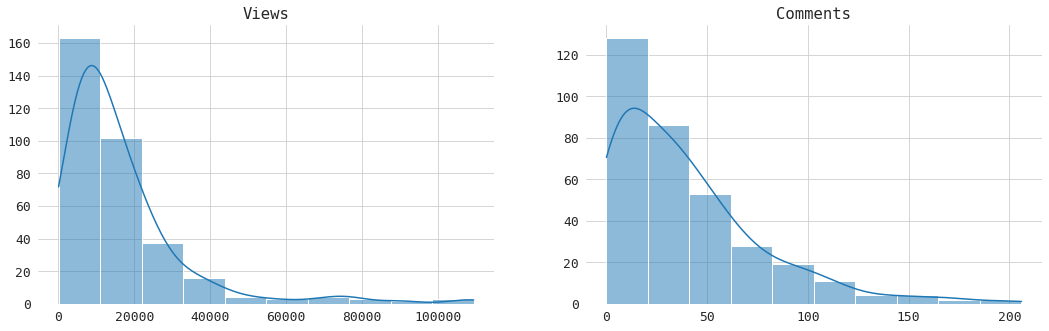

In [ ]:
# creating a double histograms function
def getHistPlots(x1,x2,title1,title2):
  fig = plt.figure()
  plt.subplot(121)
  left = sns.histplot(x1, kde=True, bins=10, palette="Blues_r")
  sns.despine(left=True, right=True, top=True, bottom=True)
  plt.xlabel("")
  plt.ylabel('')
  left.set_title(title1)
  plt.subplot(122)
  right = sns.histplot(x2, kde=True, bins=10, palette="Blues_r")
  sns.despine(left=True, right=True, top=True, bottom=True)
  plt.xlabel("")
  plt.ylabel("")
  right.set_title(title2)
  plt.subplots_adjust(wspace = 0.2, hspace = 0.4, top = 0.9)
  plt.show()

# plotting the values that had the largest range in the groupby plot above
getHistPlots(df["views"],df["comments"],"Views","Comments")

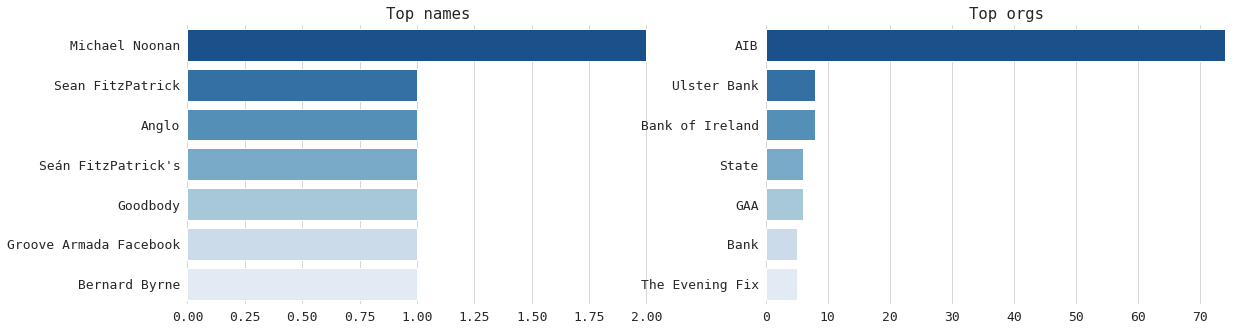

In [ ]:
# function to count the most present elements within a list
def getCount(serie, howmany):
  counted = Counter(serie)
  labels = [l for l,v in counted.most_common(howmany)]
  values = [v for l,v in counted.most_common(howmany)]
  result = pd.DataFrame({"labels":labels, "values":values})
  return result

# building a side by side bar plot on Seaborn
def getBarCharts(x1,y1,x2,y2,my_title1,my_title2):
  fig = plt.figure(figsize=(19,5))
  plt.subplot(121)
  left = sns.barplot(x=x1, y=y1, orient='h', palette='Blues_r')
  sns.despine(left=True, right=True, top=True, bottom=True)
  plt.xlabel('')
  plt.ylabel('')
  left.set_title(my_title1)
  plt.subplot(122)
  right = sns.barplot(x=x2, y=y2, orient='h', palette='Blues_r')
  sns.despine(left=True, right=True, top=True, bottom=True)
  plt.xlabel('')
  plt.ylabel('')
  right.set_title(my_title2)
  plt.subplots_adjust(wspace = 0.2, hspace = 0.4, top = 0.9)
  plt.show()

ents = getCount([e[0] for e in entities if e[1] == "PERSON"], 7)
toks = getCount([e[0] for e in entities if e[1] == "ORG"], 7)

getBarCharts(ents["values"], ents["labels"],
             toks["values"], toks["labels"],
             "Top names", "Top orgs"
             )

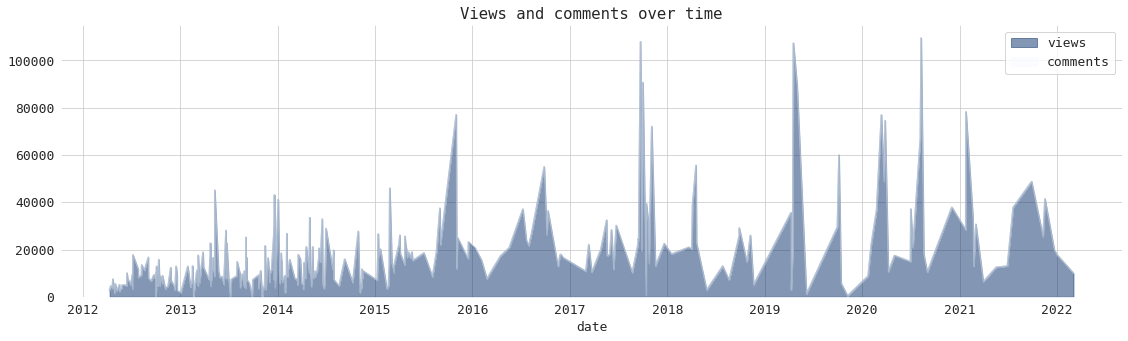

In [ ]:
df.plot(figsize=(19,5),
        kind="area",
        x="date",
        stacked=True,
        cmap="Blues_r",
        alpha=0.5,
        title="Views and comments over time"
        );

# **Text cleaning functions**

In [ ]:
# helps prevent text formatting issues
!pip install unidecode

     |████████████████████████████████| 235 kB 5.3 MB/s 


In [ ]:
# data
import pandas as pd
from google.colab import files

# text cleaning
import re
import nltk.corpus
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

In [ ]:
# downloading NLTK's data
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# local csv
files.upload()

Saving thesis_journal.csv to thesis_journal.csv


{'thesis_journal.csv': b',date,article,views,comments\n0,"Mar 3rd 2022, 12:41 PM",AIB returns to profit as discussions underway to buy back some State shares,"9,969  Views", 11 Comments\n1,"Dec 31st 2021, 4:43 PM",Competition watchdog to fully investigate AIB and Ulster Bank loan book deal,"17,776  Views", 12 Comments\n2,"Dec 21st 2021, 8:48 AM","State to sell 15% chunk of its AIB stake over the next six months, Donohoe announces","19,824  Views", 33 Comments\n3,"Nov 16th 2021, 3:26 PM",Sean FitzPatrick remembered by family as a \xe2\x80\x98giant of a man\xe2\x80\x99,"41,407  Views", 0 Comments\n4,"Nov 9th 2021, 6:48 PM",Anglo\'s collapse has had an outsized impact on Irish life and so will Se\xc3\xa1n FitzPatrick\'s legacy,"25,421  Views", 2 Comments\n5,"Sep 27th 2021, 4:57 PM",College student accused of having \xe2\x82\xac22k in money stolen during smishing attacks on AIB customers,"48,732  Views", 0 Comments\n6,"Jul 20th 2021, 10:46 AM",Ireland\'s bank network \'is being destroyed\'

In [ ]:
# dataframe
df = pd.read_csv("thesis_journal.csv")
df = df.filter(["article"])
df.head(3)

,article
0,AIB returns to profit as discussions underway ...
1,Competition watchdog to fully investigate AIB ...
2,State to sell 15% chunk of its AIB stake over ...


In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def getLems(listOfTokens):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    #param_stemmer = SnowballStemmer(language)    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        
        listOfTokens = getLems(listOfTokens)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

corpus = df["article"].to_list()
language = "english"
corpus = processCorpus(corpus, language)

In [ ]:
# tfid vectorizer
def getVects(corpus):
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(corpus)
  tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
  processed = tf_idf
  return processed

vecs = getVects(corpus)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# top 5 words
vecs.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,327,328,329,330,331,332,333,334,335,336
discussion,0.409566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
underway,0.409566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
buy,0.363254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
return,0.363254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
profit,0.336163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Coherence score**

In [ ]:
# libraries
from gensim.test.utils import common_corpus, common_dictionary
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
# list of lists of tokens
sample = [
          ["banana", "apple"],
          ["cat","dog"]
          ]

In [ ]:
def getPalmettoScore(topics):
  cm = CoherenceModel(topics=topics,
                      corpus=common_corpus,
                      dictionary=common_dictionary,
                      coherence="u_mass")
  coherence = cm.get_coherence()
  print(coherence)

getPalmettoScore(sample)

In [ ]:
!pip install palmettopy

In [ ]:
from palmettopy.palmetto import Palmetto

In [ ]:
def getPalmettoScore(tokens):
  palmetto = Palmetto("http://palmetto.cs.upb.de:8080/service/")
  coherences = ["ca", "cp", "cv", "npmi", "uci", "umass"]
  for c in coherences:
    print(f"Coherence score for {c.upper():<7}->\t", palmetto.get_coherence(tokens, coherence_type=c))

words = ["mango", "apple", "banana", "cherry", "peach"]
getPalmettoScore(words)

Coherence score for CA     ->	 0.43288899186379143
Coherence score for CP     ->	 0.9191168240347682
Coherence score for CV     ->	 0.6094046937088666
Coherence score for NPMI   ->	 0.3017938560627863
Coherence score for UCI    ->	 4.068299964236472
Coherence score for UMASS  ->	 -3.0617138195583458


# **Classical K-Means clustering**

In [ ]:
# extra installs
!pip install kneed
!pip install texthero

     |████████████████████████████████| 235 kB 7.1 MB/s 
     |████████████████████████████████| 1.5 MB 39.8 MB/s 
     |████████████████████████████████| 749 kB 43.6 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
# libraries
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib import style
from google.colab import files
from collections import Counter
import numpy as np
import seaborn as sns

# kmeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
import texthero as hero
from texthero import preprocessing

# text cleaning
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

In [ ]:
# downloading stopwords and punkt
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
# loading one of the datasets
files.upload()

Saving thesis_journal.csv to thesis_journal.csv


{'thesis_journal.csv': b',date,article,views,comments\n0,"Mar 3rd 2022, 12:41 PM",AIB returns to profit as discussions underway to buy back some State shares,"9,969  Views", 11 Comments\n1,"Dec 31st 2021, 4:43 PM",Competition watchdog to fully investigate AIB and Ulster Bank loan book deal,"17,776  Views", 12 Comments\n2,"Dec 21st 2021, 8:48 AM","State to sell 15% chunk of its AIB stake over the next six months, Donohoe announces","19,824  Views", 33 Comments\n3,"Nov 16th 2021, 3:26 PM",Sean FitzPatrick remembered by family as a \xe2\x80\x98giant of a man\xe2\x80\x99,"41,407  Views", 0 Comments\n4,"Nov 9th 2021, 6:48 PM",Anglo\'s collapse has had an outsized impact on Irish life and so will Se\xc3\xa1n FitzPatrick\'s legacy,"25,421  Views", 2 Comments\n5,"Sep 27th 2021, 4:57 PM",College student accused of having \xe2\x82\xac22k in money stolen during smishing attacks on AIB customers,"48,732  Views", 0 Comments\n6,"Jul 20th 2021, 10:46 AM",Ireland\'s bank network \'is being destroyed\'

In [ ]:
# plotting style
sns.set_style("whitegrid")

# dataframe
df = pd.read_csv("thesis_journal.csv")
df = df.filter(["article"])
df.head(3)

,article
0,AIB returns to profit as discussions underway ...
1,Competition watchdog to fully investigate AIB ...
2,State to sell 15% chunk of its AIB stake over ...


In [ ]:
# cleaning the text
def getCleanText(serie):
  stop_words=set(nltk.corpus.stopwords.words("english"))
  lem = WordNetLemmatizer()
  tokens = word_tokenize(str(serie))
  tokens = [lem.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 3]
  cleaned = " ".join(tokens)
  return cleaned

df["cleaned"] = df["article"].apply(getCleanText)
df["vectorized"] = (hero.tfidf(df["cleaned"], max_features=3000))

df.sample(3)

,article,cleaned,vectorized
68,Details of 550 customer accounts 'mislaid' by AIB,Details customer account 'mislaid,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
330,Priory Hall residents: Mortgages can’t be deal...,Priory Hall resident Mortgages dealt case-by-c...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
201,Here’s What Happened Today: Thursday,Here What Happened Today Thursday,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# values as unicode
document = df["cleaned"].values.astype("U")

# model
def getVectors(doc):
  try:
    vectorizer = TfidfVectorizer(stop_words="english")
    features = vectorizer.fit_transform(doc)
    return features
  except Exception as e:
    print(e)

def getKMeans(howmany,vects):
  data = getVectors(vects)
  try:
    model = KMeans(n_clusters = howmany, init="k-means++", max_iter=100, n_init=1)
    model.fit(data)
    return model
  except Exception as e:
    print(e)

model = getKMeans(3,document)

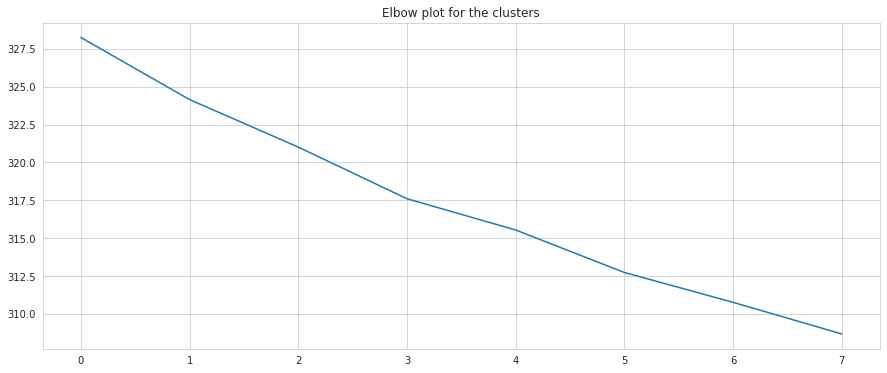

In [ ]:
# to determine how many clusters can be identified within the dataset, we use an elbow plot
inertias = [] # where we will store our inertias
sizes = range(2,10) # we don't know how many clusters we have, so we're saying "between  2 and 10"

vects = getVectors(document)

# looping through the cluster estimations, and appending data to our empty list
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)
    k2.fit(vects)
    inertias.append(k2.inertia_)
    
# plotting a simple line chart
plt.figure(figsize=(15,6))
plt.title("Elbow plot for the clusters")
plt.plot(inertias)
plt.show()

In [ ]:
# going with 3 topics
def getKMeans(howmany,data):
  try:
    model = KMeans(n_clusters = howmany, init="k-means++", max_iter=100, n_init=1)
    model.fit(data)
    return model
  except Exception as e:
    print(e)

model = getKMeans(3,vects)

In [ ]:
# centroids for each cluster
def getCentroids():
  vectorizer = TfidfVectorizer()
  order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  vectorizer = TfidfVectorizer(stop_words="english")
  features = vectorizer.fit_transform(document)
  terms = vectorizer.get_feature_names()

  for i in range(0,3):
      print("\nTopic %d:" % i, "\n")
      for j in order_centroids[i, :5]: #print out 8 feature terms of each cluster
          print (' %s' % terms[j])
      #print("\n------------\n")

getCentroids()


Topic 0: 

 ireland
 today
 club
 year
 happened

Topic 1: 

 bank
 mortgage
 say
 rate
 government

Topic 2: 

 customer
 money
 payment
 overcharged
 pocket


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# silhouette score
from sklearn import cluster
def getSilhouette(data):
  for i in range(2,10):
    labels = cluster.KMeans(n_clusters = i, init="k-means++", random_state=200).fit(data).labels_
    score = metrics.silhouette_score(data, labels, metric="euclidean", sample_size=1000, random_state=200)
    print(f"Silhouette score for cluster number {i} is: {str(score)}")

getSilhouette(vects)

Silhouette score for cluster number 2 is: 0.009059663136443361
Silhouette score for cluster number 3 is: 0.009440567067200725
Silhouette score for cluster number 4 is: 0.013862115591754199
Silhouette score for cluster number 5 is: 0.015817728680703944
Silhouette score for cluster number 6 is: 0.018780550771803437
Silhouette score for cluster number 7 is: 0.013435397567301804
Silhouette score for cluster number 8 is: 0.020632912058702844
Silhouette score for cluster number 9 is: 0.019537720643023122


<Figure size 1080x360 with 0 Axes>

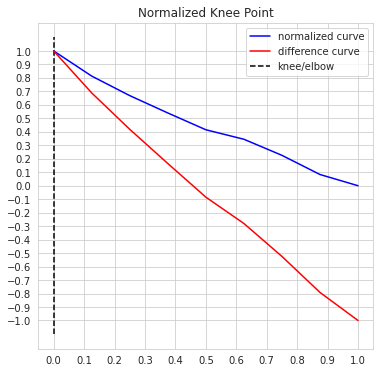

In [ ]:
def getKneePlot(data):
  sse = {}
  for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=1)
    kmeans.fit(data)
    sse[k] = kmeans.inertia_

  kneedle = KneeLocator(x=list(sse.keys()), 
                        y=list(sse.values()),
                        curve="concave", 
                        direction="increasing"
                        )
  plt.figure(figsize=(15,5))
  kneedle.plot_knee_normalized();
  plt.show();

getKneePlot(vects)

# **Using BERTopic**

In [ ]:
# at the moment BERTopic isn't natively supported in Colab

!pip install bertopic
!pip install bertopic[visualization]

# palmetto score
!pip install palmettopy

     |████████████████████████████████| 58 kB 5.5 MB/s 
     |████████████████████████████████| 88 kB 7.0 MB/s 
     |████████████████████████████████| 5.2 MB 34.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 4.0 MB 20.8 MB/s 
     |████████████████████████████████| 1.2 MB 18.0 MB/s 
     |████████████████████████████████| 77 kB 5.0 MB/s 
     |████████████████████████████████| 636 kB 39.3 MB/s 
     |████████████████████████████████| 6.6 MB 40.4 MB/s 
     |████████████████████████████████| 880 kB 40.3 MB/s 
     |████████████████████████████████| 1.1 MB 38.8 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330819 sha256=2dee53c79f48ff3fa56b3d949bdf89d84f69bbb2c4feb698563dee3d7b4f6360
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef

In [ ]:
#import packages

import pandas as pd 
import numpy as np
from bertopic import BERTopic
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from google.colab import files
from palmettopy.palmetto import Palmetto

In [ ]:
# importing a locally saved csv
files.upload()

Saving thesis_journal.csv to thesis_journal.csv


{'thesis_journal.csv': b',date,article,views,comments\n0,"Mar 3rd 2022, 12:41 PM",AIB returns to profit as discussions underway to buy back some State shares,"9,969  Views", 11 Comments\n1,"Dec 31st 2021, 4:43 PM",Competition watchdog to fully investigate AIB and Ulster Bank loan book deal,"17,776  Views", 12 Comments\n2,"Dec 21st 2021, 8:48 AM","State to sell 15% chunk of its AIB stake over the next six months, Donohoe announces","19,824  Views", 33 Comments\n3,"Nov 16th 2021, 3:26 PM",Sean FitzPatrick remembered by family as a \xe2\x80\x98giant of a man\xe2\x80\x99,"41,407  Views", 0 Comments\n4,"Nov 9th 2021, 6:48 PM",Anglo\'s collapse has had an outsized impact on Irish life and so will Se\xc3\xa1n FitzPatrick\'s legacy,"25,421  Views", 2 Comments\n5,"Sep 27th 2021, 4:57 PM",College student accused of having \xe2\x82\xac22k in money stolen during smishing attacks on AIB customers,"48,732  Views", 0 Comments\n6,"Jul 20th 2021, 10:46 AM",Ireland\'s bank network \'is being destroyed\'

In [ ]:
# downloading stopwords and punkt
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
# dataframe
df = pd.read_csv("thesis_journal.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df["article"] = df["article"].dropna()

In [ ]:
# preparing the data
def getCleanText(serie):
  stop_words=set(nltk.corpus.stopwords.words("english"))
  lem = WordNetLemmatizer()
  tokens = word_tokenize(str(serie))
  tokens = [lem.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 3]
  cleaned = " ".join(tokens)
  return cleaned

df["cleaned"] = df["article"].apply(getCleanText)

corpus = df["cleaned"].to_list()

df.sample(3)

,date,article,views,comments,cleaned
191,"Jan 17th 2014, 1:33 PM",Noonan says bank debt deal cannot be 'actively...,"15,198 Views",11 Comments,Noonan say bank debt deal 'actively pursued 2015
183,"Feb 4th 2014, 10:37 PM",AIB will write off debt for some split mortgag...,"11,412 Views",29 Comments,write debt split mortgage holder
141,"Jul 30th 2014, 11:37 PM",Here's What Happened Today: Wednesday,"19,672 Views",1 Comment,Here What Happened Today Wednesday


In [ ]:
# for now, exploring the official documentation
try:
  topic_model = BERTopic()
  topics, probs = topic_model.fit_transform(corpus)
except Exception as e:
  print(e)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
# accessing the frequent topics. -1 refers to all outliers and should typically be ignored
topic_model.get_topic_info()

,Topic,Count,Name
0,0,277,0_bank_mortgage_irish_ireland
1,1,31,1_club_allireland_weekend_here
2,2,23,2_evening_added_today_what
3,-1,6,-1_ivan_yates_take_stage


In [ ]:
# accessing the size of topics in descending order
topic_model.get_topic_freq().head(11)

,Topic,Count
0,0,279
1,1,34
2,2,22
3,-1,2


In [ ]:
def showTopics():
  for topics in range(0, (len(topic_model.get_topic_info()) -1)):
    print(f"\nTopic: {topics + 1}\n")
    for t in topic_model.get_topic(topics):
      print("\t", t[0])

showTopics()


Topic: 1

	 bank
	 mortgage
	 irish
	 ireland
	 say
	 customer
	 banking
	 year
	 rate
	 branch

Topic: 2

	 club
	 allireland
	 weekend
	 here
	 ahead
	 final
	 bos
	 semifinals
	 happened
	 action

Topic: 3

	 evening
	 added
	 today
	 what
	 here
	 happened
	 wednesday
	 daily
	 friday
	 sunday


In [ ]:
# selecting a specific topic and get the top n words for that topic and their c-TF-IDF scores.
def getTopTopics(min_score):
  for topics in range(0, (len(topic_model.get_topic_info()) -1)):
    print(f"\nTopic: {topics + 1}\n")
    for t in topic_model.get_topic(topics):
      if t[1] >= min_score:
        print(f"\t{t[0]:<12} | \t{t[1]}")

getTopTopics(0.03)


Topic: 1

	bank         | 	0.08494979424453826
	mortgage     | 	0.06154984697330868
	irish        | 	0.03915229024686462
	ireland      | 	0.038656679832943505
	say          | 	0.03794601115404188
	customer     | 	0.03794601115404188

Topic: 2

	club         | 	0.2733361293492159
	allireland   | 	0.20301130362806058
	weekend      | 	0.10351497791860956
	here         | 	0.09257032559627693
	ahead        | 	0.08669548109840884
	final        | 	0.08669548109840884
	bos          | 	0.08669548109840884
	semifinals   | 	0.08669548109840884
	happened     | 	0.06916603563034002
	action       | 	0.06878338400640775

Topic: 3

	evening      | 	0.384086704992701
	added        | 	0.35097836782005964
	today        | 	0.30015167080856087
	what         | 	0.2987341038832118
	here         | 	0.29011730908523903
	happened     | 	0.2845077135722234
	wednesday    | 	0.20377906897357953
	daily        | 	0.16167640776763884
	friday       | 	0.11610745941899722
	sunday       | 	0.10778427184509255


In [ ]:
# we can also create bar charts out of the c-TF-IDF scores
topic_model.visualize_barchart()

In [ ]:
# intertopic distance
topic_model.visualize_topics(top_n_topics=2)

In [ ]:
# we can also see how similar certain topics are to each other
topic_model.visualize_heatmap()

In [ ]:
# top words to list
def getTopTopics(min_score=0.03):
  for topics in range(0, (len(topic_model.get_topic_info()) -1)):
    score = [t[0]for t in topic_model.get_topic(topics) if t[1] >= min_score]
    print(f"\nPalmetto score for topic {topics + 1}\n")
    getPalmettoScore(score)
    #print(score)

getTopTopics()


Pametto score for topic 1

Coherence score for CA     ->	 0.2006748233733586
Coherence score for CP     ->	 0.20782736078851413
Coherence score for CV     ->	 0.46916776694465834
Coherence score for NPMI   ->	 0.058686871825237644
Coherence score for UCI    ->	 0.5967041454657319
Coherence score for UMASS  ->	 -2.517997218468325

Pametto score for topic 2

Coherence score for CA     ->	 0.03301108995166196
Coherence score for CP     ->	 -0.5087223838293274
Coherence score for CV     ->	 0.42419851851446355
Coherence score for NPMI   ->	 -0.08356397731855224
Coherence score for UCI    ->	 -2.3710014630548115
Coherence score for UMASS  ->	 -6.517213243394131

Pametto score for topic 3

Coherence score for CA     ->	 0.09884664485312047
Coherence score for CP     ->	 -0.4629700906901249
Coherence score for CV     ->	 0.5082815982071086
Coherence score for NPMI   ->	 -0.030181525037533474
Coherence score for UCI    ->	 -1.7588253803168452
Coherence score for UMASS  ->	 -8.478036473838548


In [ ]:
#coherence score
def getPalmettoScore(tokens):
  palmetto = Palmetto("http://palmetto.cs.upb.de:8080/service/")
  coherences = ["ca", "cp", "cv", "npmi", "uci", "umass"]
  for c in coherences:
    print(f"Coherence score for {c.upper():<7}->\t", palmetto.get_coherence(tokens, coherence_type=c))

topic0 = [t[0]for t in topic_model.get_topic(0)]
#topic1 = [t[0]for t in topic_model.get_topic(1)]
#topic2 = [t[0]for t in topic_model.get_topic(2)]
getPalmettoScore(topic0)

In [ ]:
getPalmettoScore(topic1)

In [ ]:
getPalmettoScore(topic2)

# **Traditional Latent Dirichlet Allocation (Scikit Learn)**

In [ ]:
# libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from google.colab import files

In [ ]:
# temp install
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# local file
files.upload()

Saving thesis_journal.csv to thesis_journal.csv


{'thesis_journal.csv': b',date,article,views,comments\n0,"Mar 3rd 2022, 12:41 PM",AIB returns to profit as discussions underway to buy back some State shares,"9,969  Views", 11 Comments\n1,"Dec 31st 2021, 4:43 PM",Competition watchdog to fully investigate AIB and Ulster Bank loan book deal,"17,776  Views", 12 Comments\n2,"Dec 21st 2021, 8:48 AM","State to sell 15% chunk of its AIB stake over the next six months, Donohoe announces","19,824  Views", 33 Comments\n3,"Nov 16th 2021, 3:26 PM",Sean FitzPatrick remembered by family as a \xe2\x80\x98giant of a man\xe2\x80\x99,"41,407  Views", 0 Comments\n4,"Nov 9th 2021, 6:48 PM",Anglo\'s collapse has had an outsized impact on Irish life and so will Se\xc3\xa1n FitzPatrick\'s legacy,"25,421  Views", 2 Comments\n5,"Sep 27th 2021, 4:57 PM",College student accused of having \xe2\x82\xac22k in money stolen during smishing attacks on AIB customers,"48,732  Views", 0 Comments\n6,"Jul 20th 2021, 10:46 AM",Ireland\'s bank network \'is being destroyed\'

In [ ]:
# dataframe
df = pd.read_csv("thesis_journal.csv")

In [ ]:
# alternative way of cleaning the serie
def getCleanText(serie):
  stop_words=set(nltk.corpus.stopwords.words("english"))
  lem = WordNetLemmatizer()
  tokens = word_tokenize(str(serie))
  tokens = [lem.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 3]
  cleaned = " ".join(tokens)
  return cleaned

df["cleaned"] = df["article"].apply(getCleanText)

In [ ]:
# Carrying out a TFIDF vectorization on the text column
try:
  vect = TfidfVectorizer(stop_words=set(nltk.corpus.stopwords.words("english")),
                        max_features=1000
                        )
  vect_text = vect.fit_transform(df["cleaned"])
except Exception as e:
  print(e)

In [ ]:
# calling the model, with recommended parameters as per https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
try:
  model = LatentDirichletAllocation(n_components=3,
                                    learning_method="online",
                                    random_state=42,
                                    max_iter=1
                                    ) 
  lda = model.fit_transform(vect_text)
except Exception as e:
  print(e)

In [ ]:
def getPalmettoScore(tokens):
  palmetto = Palmetto("http://palmetto.cs.upb.de:8080/service/")
  coherences = ["ca", "cp", "cv", "npmi", "uci", "umass"]
  for c in coherences:
    print(f"Coherence score for {c.upper():<7}->\t", palmetto.get_coherence(tokens, coherence_type=c))

In [ ]:
def getTopics(model = model):
  vocab = vect.get_feature_names()
  for i, comp in enumerate(model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:7]
    #print("Topic " + str(i+1) + ": ")
    # for t in sorted_words:
    #   print(t[0],end=" ")
    # print("\n")
    score = " ".join([s[0] for s in sorted_words])
    print(f"\nPalmetto score for topic {i+1}\n")
    print(score)
    #getPalmettoScore(score)

getTopics()


Palmetto score for topic 1

mortgage bank ireland rate say year added

Palmetto score for topic 2

bank deal back debt money billion irish

Palmetto score for topic 3

today happened bank wednesday irish branch daily


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# **Latent Semantic Analysis (LSA)**

In [ ]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from pprint import pprint

from gensim import corpora
from gensim.models import LsiModel
from gensim.corpora import Dictionary
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from nltk import word_tokenize

In [ ]:
# reading a locally saved csv file
files.upload()

Saving thesis_irishtimes.csv to thesis_irishtimes.csv


{'thesis_irishtimes.csv': b',undertitle\n0,"Russia: Over 4,300 detained at anti-war protests in 49 cities, monitor says"\n1,BBC World News taken off air in country as work of journalists and staff temporarily suspended\n2,"Staff at Ukraine\'s Zaporizhzhia nuclear plant under Russian orders, IAEA says"\n3,The takeover comes after the largest nuclear plant in Europe was set on fire on Friday\n4,"War in Ukraine: Russia resumes shelling during agreed ceasefire, halting evacuation for second day"\n5,Pope pleads for peace as Putin says campaign in Ukraine will not end until Kyiv stops fighting\n6,"American Express, Visa and Mastercard to suspend operations in Russia"\n7,\xe2\x80\x98We are compelled to act following Russia\xe2\x80\x99s unprovoked invasion of Ukraine\xe2\x80\x99\n8,Europe faces building material shortages as energy prices soar\n9,Chief of world\xe2\x80\x99s biggest brickmaker warns of hit to supplies as Ukraine war threatens to deepen industry\xe2\x80\x99s problems\n10,Russia 

In [ ]:
# temp install
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# dataframe
df = pd.read_csv("thesis_journal.csv")
df.sample(3)

,Unnamed: 0,date,article,views,comments
220,220,"Oct 21st 2013, 11:07 AM",Banking union raises concerns as AIB considers...,"9,145 Views",70 Comments
47,47,"Aug 20th 2018, 6:10 AM",Most businesses are very worried about Brexit ...,"7,008 Views",13 Comments
18,18,"Aug 9th 2020, 12:05 AM",'There are people working in their bedrooms ke...,"109,479 Views",33 Comments


In [ ]:
# preparing the data
def getCleanText(serie):
  stop_words=set(nltk.corpus.stopwords.words("english"))
  lem = WordNetLemmatizer()
  tokens = word_tokenize(str(serie))
  tokens = [lem.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 3]
  tokens = [t.strip("'") for t in tokens]
  cleaned = " ".join(tokens)
  return cleaned

df["cleaned"] = df["article"].apply(getCleanText)

'aib returns profit discussions underway buy back state shares'

In [ ]:
def getList(text):
  corpus = text.to_list()
  data = []
  for corp in corpus:
    l = [c for c in corp.split(" ")]
    data.append(l)
  print(data)

corpus = getList(df["cleaned"])

In [ ]:
text = df["cleaned"]
documents_list = []

for line in text:
    sentence = line.strip()
    new_sentence = re.sub(r"\d","", sentence)

    documents_list.append(sentence)

print(documents_list[0])

aib returns profit discussions underway buy back state shares


In [ ]:
# Standard stop words in NLTK
stop_words = set(stopwords.words('english'))

# Add some extra characters and words as stop words
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '#', '...', 
                   '--', "'s", 'also', '&', '-', '–', '=', 'known', 'mi', 'km', '$'])

In [ ]:
processed_list = []

# Lemmatizer
lemmatizer = WordNetLemmatizer()


for doc in documents_list:
    tokens = word_tokenize(doc.lower())

    stopped_tokens = [token for token in tokens if token not in stop_words]

    lemmatized_tokens = [lemmatizer.lemmatize(i, pos="n") for i in stopped_tokens]

    processed_list.append(lemmatized_tokens)

print(processed_list[0])

['aib', 'return', 'profit', 'discussion', 'underway', 'buy', 'back', 'state', 'share']


In [ ]:
word_dictionary = Dictionary(processed_list)
document_word_matrix = [word_dictionary.doc2bow(document) for document in processed_list]
NUM_TOPICS = 3
lsi_model = LsiModel(corpus=document_word_matrix, num_topics=NUM_TOPICS, id2word=word_dictionary)
lsi_topics = lsi_model.show_topics(num_topics=NUM_TOPICS, formatted=False)

In [ ]:
lsi_topics = lsi_model.show_topics(num_topics=NUM_TOPICS, formatted=False)

In [ ]:
pprint(lsi_topics)

[(0,
  [('aib', 0.8617265338573019),
   ('bank', 0.23189477766547878),
   ('mortgage', 0.2135723108001377),
   ('ireland', 0.13165337497603044),
   ('say', 0.1013993981891887),
   ('customer', 0.09838092253114726),
   ('year', 0.08382156442706633),
   ('new', 0.07054193483085779),
   ('billion', 0.06761867925117432),
   ('back', 0.06627575960059262)]),
 (1,
  [('bank', -0.8493965519485883),
   ('aib', 0.3233563090533664),
   ('ireland', -0.14427203542619516),
   ('ulster', -0.13965327246754405),
   ('say', -0.1328134787253612),
   ('irish', -0.09843175076725562),
   ('debt', -0.09451169458344987),
   ('deal', -0.08633299014881703),
   ('new', -0.06927299853247962),
   ('mortgage', -0.058082108072722294)]),
 (2,
  [('mortgage', -0.7091906681525844),
   ('ireland', 0.3957144504551325),
   ('club', 0.21538495249360276),
   ('rate', -0.21449400369125293),
   ('final', 0.16633331999042703),
   ('arrears', -0.12930948616066235),
   ('holder', -0.12738598393410466),
   ('semi', 0.108645277959

# **LDA with Gensim**

In [ ]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from google.colab import files
from pprint import pprint

from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from gensim.corpora import MmCorpus
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords

In [ ]:
# temp install
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# dataframe
df.sample(3)

,date,article,views,comments,cleaned
38,"Apr 18th 2019, 12:05 AM",'I left feeling like s**t': AIB criticised for...,"107,327 Views",150 Comments,left feeling like s**t criticised 'presuming I...
328,"May 8th 2012, 1:09 PM",AIB launches €250m investment programme for Ag...,"2,487 Views",13 Comments,launch €250m investment programme Agri-sector
27,"Mar 13th 2020, 7:11 PM",AIB suspending new contactless fee due to Covi...,"76,964 Views",67 Comments,suspending contactless Covid-19


In [ ]:
# another alternative way of cleaning data
stopwords = nltk.corpus.stopwords.words("english")

def getCleaned(df):
  df = df.dropna()
  df["article"] = df["article"].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
  df["article"] = df["article"].apply(lambda x: re.sub(r'\d', '', x))
  return df

def getPreprocessed(df):
  df = getCleaned(df)
  df["article"] = \
  df["article"].apply(lambda x: \
  simple_preprocess(x, deacc=True))
  df["article"] = \
  df["article"].apply(lambda x: [word for word in x if \
  word not in stopwords])
  return df

df = getPreprocessed(df)

In [ ]:
# creating the model
def getLDA(id_dict, corpus, num_topics):
  lda_model = LdaModel(corpus=corpus,
  id2word=id_dict,
  num_topics=num_topics,
  random_state=100,
  chunksize=100,
  passes=10)
  return lda_model

In [ ]:
# Dictionary object and corpus
texts = df["article"].values
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(text) for text in texts]

# randomly set 5 topics and create the LDA model
tops = 5
try:
  lda_model = getLDA(id_dict,
                    corpus,
                    tops
                    )
except Exception as e:
  print(e)

In [ ]:
# results
pprint(lda_model.print_topics())

[(0,
  '0.041*"aib" + 0.035*"mortgage" + 0.024*"today" + 0.014*"cent" + 0.014*"per" '
  '+ 0.013*"arrears" + 0.012*"interest" + 0.012*"charges" + 0.010*"branches" + '
  '0.010*"people"'),
 (1,
  '0.029*"aib" + 0.028*"bank" + 0.026*"banks" + 0.023*"says" + 0.016*"staff" + '
  '0.015*"ulster" + 0.014*"loan" + 0.013*"half" + 0.012*"pension" + '
  '0.011*"irish"'),
 (2,
  '0.030*"aib" + 0.023*"ireland" + 0.020*"club" + 0.014*"banks" + '
  '0.013*"government" + 0.010*"irish" + 0.010*"banking" + 0.010*"claims" + '
  '0.009*"semi" + 0.009*"yates"'),
 (3,
  '0.073*"aib" + 0.021*"cut" + 0.020*"bank" + 0.019*"billion" + '
  '0.016*"ireland" + 0.013*"branch" + 0.011*"closures" + 0.011*"pay" + '
  '0.011*"back" + 0.011*"changes"'),
 (4,
  '0.040*"aib" + 0.030*"fix" + 0.017*"evening" + 0.014*"banking" + '
  '0.013*"daily" + 0.013*"added" + 0.011*"mortgages" + 0.011*"public" + '
  '0.010*"credit" + 0.010*"reports"')]


# **Non-Negative Matrix Factorization (NMF) topic modeling**

In [ ]:
# nmf is new, and we need a new version of Gensim for Colab
# https://github.com/googlecolab/colabtools/issues/1983
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# libraries
import re
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from google.colab import files

from gensim.models.nmf import Nmf
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords

In [ ]:
# temp install
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# reading a locally saved csv file
files.upload()

Saving thesis_journal.csv to thesis_journal.csv


{'thesis_journal.csv': b',date,article,views,comments\n0,"Mar 3rd 2022, 12:41 PM",AIB returns to profit as discussions underway to buy back some State shares,"9,969  Views", 11 Comments\n1,"Dec 31st 2021, 4:43 PM",Competition watchdog to fully investigate AIB and Ulster Bank loan book deal,"17,776  Views", 12 Comments\n2,"Dec 21st 2021, 8:48 AM","State to sell 15% chunk of its AIB stake over the next six months, Donohoe announces","19,824  Views", 33 Comments\n3,"Nov 16th 2021, 3:26 PM",Sean FitzPatrick remembered by family as a \xe2\x80\x98giant of a man\xe2\x80\x99,"41,407  Views", 0 Comments\n4,"Nov 9th 2021, 6:48 PM",Anglo\'s collapse has had an outsized impact on Irish life and so will Se\xc3\xa1n FitzPatrick\'s legacy,"25,421  Views", 2 Comments\n5,"Sep 27th 2021, 4:57 PM",College student accused of having \xe2\x82\xac22k in money stolen during smishing attacks on AIB customers,"48,732  Views", 0 Comments\n6,"Jul 20th 2021, 10:46 AM",Ireland\'s bank network \'is being destroyed\'

In [ ]:
# dataframe
df = pd.read_csv("thesis_journal.csv")
df["article"] = df["article"].dropna()
df.sample(3)

,Unnamed: 0,date,article,views,comments
125,125,"Feb 14th 2015, 7:45 AM",5 talking points ahead of this weekend’s AIB A...,"3,383 Views",1 Comment
123,123,"Feb 23rd 2015, 6:28 PM",Happy days - there's lots of good news out the...,"13,698 Views",15 Comments
23,23,"May 1st 2020, 6:30 AM",'Worst on record' job losses as over 40% of ma...,"17,454 Views",13 Comments


In [ ]:
# another alternative way of cleaning data
stopwords = nltk.corpus.stopwords.words("english")

def getCleaned(df):
  df = df.dropna()
  df["article"] = df["article"].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
  df["article"] = df["article"].apply(lambda x: re.sub(r'\d', '', x))
  return df

def getPreprocessed(df):
  df = getCleaned(df)
  df["article"] = \
  df["article"].apply(lambda x: \
  simple_preprocess(x, deacc=True))
  df["article"] = \
  df["article"].apply(lambda x: [word for word in x if \
  word not in stopwords])
  return df

df = getPreprocessed(df)

In [ ]:
# creating the model
def getNMF(id_dict, corpus, num_topics):
  nmf_model = Nmf(corpus=corpus,
  id2word=id_dict,
  num_topics=num_topics,
  random_state=100,
  chunksize=100,
  passes=50)
  return nmf_model

In [ ]:
def getCoherence(id_dict, corpus, texts):
  num_topics_range = range(2, 10)
  coherences = []
  for num_topics in num_topics_range:
        nmf_model = getNMF(id_dict, corpus, num_topics)
        coherence_model_nmf = CoherenceModel(model=nmf_model, texts=texts, dictionary=id_dict, coherence="c_npmi")
        coherences.append(coherence_model_nmf.get_coherence())
  plt.plot(num_topics_range, coherences, color="blue", marker="o", markersize=5)
  plt.title("Coherence as a function of number of topics")
  plt.xlabel("Number of topics")
  plt.ylabel("Coherence")
  plt.grid()
  plt.show()

In [ ]:
# Dictionary object and corpus
texts = df["article"].values
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(text) for text in texts]

# randomly set 5 topics and create the LDA model
try:
  tops = 3
  nmf_model = getNMF(id_dict,
                     corpus,
                     tops
                     )
except Exception as e:
  print(e)

In [ ]:
# print the topics
pprint(nmf_model.print_topics())

[(0,
  '0.140*"aib" + 0.015*"ireland" + 0.012*"back" + 0.012*"club" + 0.011*"year" '
  '+ 0.011*"customers" + 0.010*"money" + 0.009*"billion" + 0.008*"government" '
  '+ 0.008*"staff"'),
 (1,
  '0.113*"mortgage" + 0.069*"aib" + 0.035*"rates" + 0.026*"says" + '
  '0.025*"holders" + 0.024*"banks" + 0.019*"arrears" + 0.014*"interest" + '
  '0.011*"new" + 0.011*"tracker"'),
 (2,
  '0.104*"bank" + 0.038*"ireland" + 0.029*"ulster" + 0.018*"says" + '
  '0.017*"deal" + 0.015*"new" + 0.014*"banks" + 0.013*"debt" + 0.013*"irish" + '
  '0.009*"guarantee"')]


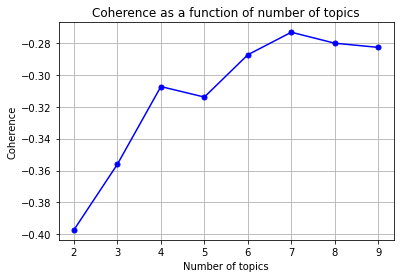

In [ ]:
# using the coherence plot
getCoherence(id_dict, corpus, texts)

# **K-means topic modeling with BERT**

In [ ]:
# not on Colab
!pip install sentence_transformers

     |████████████████████████████████| 79 kB 3.0 MB/s 
     |████████████████████████████████| 3.8 MB 9.2 MB/s 
     |████████████████████████████████| 1.2 MB 46.1 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 54.9 MB/s 
     |████████████████████████████████| 895 kB 42.9 MB/s 
     |████████████████████████████████| 6.5 MB 30.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=3c1f996ed4e9c380a9ea6a1dbab16300e2663d5a6f7759cf4115108bb4362d41
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# libraries
import re
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import string
from google.colab import files

from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords

In [ ]:
# reading a locally saved csv file
files.upload()

Saving thesis_irishtimes.csv to thesis_irishtimes (3).csv


{'thesis_irishtimes.csv': b',undertitle\n0,"Russia: Over 4,300 detained at anti-war protests in 49 cities, monitor says"\n1,BBC World News taken off air in country as work of journalists and staff temporarily suspended\n2,"Staff at Ukraine\'s Zaporizhzhia nuclear plant under Russian orders, IAEA says"\n3,The takeover comes after the largest nuclear plant in Europe was set on fire on Friday\n4,"War in Ukraine: Russia resumes shelling during agreed ceasefire, halting evacuation for second day"\n5,Pope pleads for peace as Putin says campaign in Ukraine will not end until Kyiv stops fighting\n6,"American Express, Visa and Mastercard to suspend operations in Russia"\n7,\xe2\x80\x98We are compelled to act following Russia\xe2\x80\x99s unprovoked invasion of Ukraine\xe2\x80\x99\n8,Europe faces building material shortages as energy prices soar\n9,Chief of world\xe2\x80\x99s biggest brickmaker warns of hit to supplies as Ukraine war threatens to deepen industry\xe2\x80\x99s problems\n10,Russia 

In [ ]:
# temp install
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# dataframe
df = pd.read_csv("thesis_journal.csv")
df["article"] = df["article"].dropna()
df.sample(3)

,Unnamed: 0,date,article,views,comments
325,325,"May 22nd 2012, 1:11 PM",Ulster Bank says banking charges 'under review...,"3,246 Views",17 Comments
247,247,"Jun 13th 2013, 10:00 PM",Why is a former AIB building bought by the Sta...,"5,166 Views",25 Comments
95,95,"Jan 11th 2016, 4:37 PM",Joan Burton says questions about bank debt dea...,"20,644 Views",193 Comments


In [ ]:
# another alternative way of cleaning data
stopwords = nltk.corpus.stopwords.words("english")

def getCleaned(df):
  df = df.dropna()
  df["article"] = df["article"].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
  df["article"] = df["article"].apply(lambda x: re.sub(r'\d', '', x))
  return df

def getPreprocessed(df):
  df = getCleaned(df)
  df["article"] = df["article"].apply(lambda x: simple_preprocess(x, deacc=True))
  df["article"] = df["article"].apply(lambda x: [word for word in x if word not in stopwords])
  return df

df = getPreprocessed(df)
df

,Unnamed: 0,date,article,views,comments
0,0,"Mar 3rd 2022, 12:41 PM","[aib, returns, profit, discussions, underway, ...","9,969 Views",11 Comments
1,1,"Dec 31st 2021, 4:43 PM","[competition, watchdog, fully, investigate, ai...","17,776 Views",12 Comments
2,2,"Dec 21st 2021, 8:48 AM","[state, sell, chunk, aib, stake, next, six, mo...","19,824 Views",33 Comments
3,3,"Nov 16th 2021, 3:26 PM","[sean, fitzpatrick, remembered, family, giant,...","41,407 Views",0 Comments
4,4,"Nov 9th 2021, 6:48 PM","[anglo, collapse, outsized, impact, irish, lif...","25,421 Views",2 Comments
...,...,...,...,...,...
332,332,"Apr 23rd 2012, 11:24 AM","[ireland, recorded, per, cent, deficit, last, ...","7,515 Views",117 Comments
333,333,"Apr 21st 2012, 12:57 PM","[aib, employees, continue, earn, basic, salaries]","3,565 Views",9 Comments
334,334,"Apr 15th 2012, 11:47 AM","[public, demand, full, investigation, banking,...","4,635 Views",27 Comments
335,335,"Apr 11th 2012, 8:06 PM","[daily, fix, wednesday]","2,631 Views",41 Comments


In [ ]:
def test_new_example(km, model, example):
  embedded = model.encode([example])
  topic = km.predict(embedded)[0]
  print(topic)
  return topic

In [ ]:
df["article"] = df["article"].apply(lambda x: " ".join(x))
documents = df["article"].values

In [ ]:
try:
  model = SentenceTransformer("distilbert-base-nli-mean-tokens")
  encoded_data = model.encode(documents)
except Exception as e:
  print(e)

In [ ]:
km = KMeans(n_clusters=5, random_state=0)
km.fit(encoded_data)

KMeans(n_clusters=5, random_state=0)

In [ ]:
def tokenize_nltk(text):
  return nltk.tokenize.word_tokenize(text)

def get_most_frequent_words(text):
  word_list = tokenize_nltk(text)
  word_list = [word for word in word_list if word not in stopwords and word not in string.punctuation and re.search('[a-zA-Z]', word)]
  freq_dist = FreqDist(word_list)
  top_200 = freq_dist.most_common(200)
  top_200 = [word[0] for word in top_200]
  return top_200

def print_most_common_words_by_cluster(all_training, km, num_clusters):
  clusters = km.labels_.tolist()
  docs = {'text': all_training, 'cluster': clusters}
  frame = pd.DataFrame(docs, index = [clusters])
  for cluster in range(0, num_clusters):
    this_cluster_text = frame[frame['cluster'] == cluster]
    all_text = " ".join(this_cluster_text['text'].astype(str))
    top_200 = get_most_frequent_words(all_text)
    print(cluster)
    print(top_200)
  return frame

In [ ]:
print_most_common_words_by_cluster(documents, km, 5)

0
['aib', 'billion', 'bank', 'customers', 'year', 'million', 'mortgage', 'increase', 'banks', 'money', 'pay', 'new', 'back', 'rates', 'tax', 'ireland', 'bankers', 'irish', 'ulster', 'deal', 'last', 'three', 'mortgages', 'fans', 'paying', 'get', 'first', 'home', 'week', 'pre', 'profit', 'half', 'debt', 'column', 'today', 'smishing', 'attacks', 'agrees', 'spend', 'month', 'hotels', 'says', 'overcharged', 'nearly', 'decade', 'bailout', 'wants', 'turn', 'government', 'sale', 'homes', 'could', 'years', 'rage', 'repossessions', 'high', 'loans', 'going', 'start', 'billions', 'state', 'enough', 'taxpayers', 'two', 'buyers', 'viewing', 'vital', 'round', 'property', 'news', 'made', 'much', 'rate', 'sme', 'banking', 'holders', 'raise', 'interest', 'bond', 'bondholders', 'college', 'student', 'accused', 'stolen', 'take', 'worth', 'corporate', 'commercial', 'loan', 'book', 'topped', 'financial', 'ombudsman', 'complaints', 'table', 'second', 'row', 'landmark', 'buy', 'stockbrokers', 'goodbody', 'hit

,text,cluster
1,aib returns profit discussions underway buy ba...,1
1,competition watchdog fully investigate aib uls...,1
3,state sell chunk aib stake next six months don...,3
2,sean fitzpatrick remembered family giant man,2
2,anglo collapse outsized impact irish life sean...,2
...,...,...
4,ireland recorded per cent deficit last year,4
3,aib employees continue earn basic salaries,3
1,public demand full investigation banking crisi...,1
3,daily fix wednesday,3


# **Gibbs Sampling Algorithm for Dirichlet Multinomial Mixture (GSDMM)**

In [ ]:
# https://towardsdatascience.com/short-text-topic-modelling-lda-vs-gsdmm-20f1db742e14
!pip install git+https://github.com/rwalk/gsdmm.git

  Cloning https://github.com/rwalk/gsdmm.git to /tmp/pip-req-build-puydwvh8
  Running command git clone -q https://github.com/rwalk/gsdmm.git /tmp/pip-req-build-puydwvh8
  Created wheel for gsdmm: filename=gsdmm-0.1-py3-none-any.whl size=4602 sha256=f41790aa2bd831a6871b52d9bbc768ea21edbac13b76864bfc90dea1ca74809c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ydbc2wph/wheels/34/65/a6/7eef67b88abae954fecd22587bd755c27b58a9ffe488d6b0de
Successfully built gsdmm


In [ ]:
# libraries
import re
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from google.colab import files

import spacy
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
import numpy as np
import string
from gsdmm import MovieGroupProcess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk import word_tokenize

In [ ]:
# temp install
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# reading a locally saved csv file
files.upload()

Saving thesis_journal.csv to thesis_journal.csv


{'thesis_journal.csv': b',date,article,views,comments\n0,"Mar 3rd 2022, 12:41 PM",AIB returns to profit as discussions underway to buy back some State shares,"9,969  Views", 11 Comments\n1,"Dec 31st 2021, 4:43 PM",Competition watchdog to fully investigate AIB and Ulster Bank loan book deal,"17,776  Views", 12 Comments\n2,"Dec 21st 2021, 8:48 AM","State to sell 15% chunk of its AIB stake over the next six months, Donohoe announces","19,824  Views", 33 Comments\n3,"Nov 16th 2021, 3:26 PM",Sean FitzPatrick remembered by family as a \xe2\x80\x98giant of a man\xe2\x80\x99,"41,407  Views", 0 Comments\n4,"Nov 9th 2021, 6:48 PM",Anglo\'s collapse has had an outsized impact on Irish life and so will Se\xc3\xa1n FitzPatrick\'s legacy,"25,421  Views", 2 Comments\n5,"Sep 27th 2021, 4:57 PM",College student accused of having \xe2\x82\xac22k in money stolen during smishing attacks on AIB customers,"48,732  Views", 0 Comments\n6,"Jul 20th 2021, 10:46 AM",Ireland\'s bank network \'is being destroyed\'

In [ ]:
# dataframe
df = pd.read_csv("thesis_journal.csv")
df["article"] = df["article"].dropna()
# removing null values
df = df.dropna()
df.sample(3)

,Unnamed: 0,date,article,views,comments
328,328,"May 8th 2012, 1:09 PM",AIB launches €250m investment programme for Ag...,"2,487 Views",13 Comments
154,154,"May 26th 2014, 12:20 PM",AIB and Tony O'Reilly faced off in the Four Co...,"10,665 Views",0 Comments
297,297,"Oct 4th 2012, 2:08 PM",‘No ministerial involvement’ in selecting prim...,"5,647 Views",52 Comments


In [ ]:
# preparing the data
def getCleanText(serie):
  stop_words=set(nltk.corpus.stopwords.words("english"))
  lem = WordNetLemmatizer()
  tokens = word_tokenize(str(serie))
  tokens = [lem.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 3]
  cleaned = " ".join(tokens)
  return cleaned

df["cleaned"] = df["article"].apply(getCleanText)

In [ ]:
reviews_lemmatized = []
for cleaned in df["cleaned"]:
  clean = [c for c in cleaned.split(" ")]
  reviews_lemmatized.append(clean)

In [ ]:
mgp = MovieGroupProcess(K=3, alpha=0.01, beta=0.01, n_iters=30)
vocab = set(x for review in reviews_lemmatized for x in review)
n_terms = len(vocab)
model = mgp.fit(reviews_lemmatized, n_terms)

In stage 0: transferred 172 clusters with 3 clusters populated
In stage 1: transferred 57 clusters with 3 clusters populated
In stage 2: transferred 45 clusters with 3 clusters populated
In stage 3: transferred 37 clusters with 3 clusters populated
In stage 4: transferred 31 clusters with 3 clusters populated
In stage 5: transferred 21 clusters with 3 clusters populated
In stage 6: transferred 35 clusters with 3 clusters populated
In stage 7: transferred 36 clusters with 3 clusters populated
In stage 8: transferred 24 clusters with 3 clusters populated
In stage 9: transferred 24 clusters with 3 clusters populated
In stage 10: transferred 22 clusters with 3 clusters populated
In stage 11: transferred 29 clusters with 3 clusters populated
In stage 12: transferred 27 clusters with 3 clusters populated
In stage 13: transferred 24 clusters with 3 clusters populated
In stage 14: transferred 15 clusters with 3 clusters populated
In stage 15: transferred 24 clusters with 3 clusters populated
I

In [ ]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [ ]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 7)

Number of documents per topic : [ 87 130 120]

Most important clusters (by number of docs inside): [1 2 0]

Cluster 1 : [('mortgage', 36), ('bank', 28), ('rate', 14), ('back', 10), ('Irish', 10), ('banking', 10), ('year', 10)]

Cluster 2 : [('Bank', 21), ('bank', 20), ('Ireland', 15), ('say', 13), ('branch', 13), ('Ulster', 10), ('loan', 10)]

Cluster 0 : [('club', 17), ('Here', 14), ('All-Ireland', 12), ('Evening', 9), ('What', 8), ('added', 8), ('business', 7)]


# **Next**